# IE4483 Project 2 — Cats vs Dogs (Keras/TensorFlow)

This section loads JPG images from `datasets_subset/{train,val,test}` and builds:

- Preprocessing and augmentation pipeline
- Baseline CNN (Sequential)
- Transfer learning model (MobileNetV2)
- Training with early stopping and best-checkpoint saving
- Evaluation on test set with accuracy, precision, recall, F1, and a confusion matrix

Dependencies: TensorFlow 2.x, NumPy, Matplotlib (already in `requirements.txt`).

In [10]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

DATA_ROOT = Path('datasets_subset')
TRAIN_DIR = str(DATA_ROOT / 'train')
VAL_DIR = str(DATA_ROOT / 'val')
TEST_DIR = str(DATA_ROOT / 'test')

# Where to save trained models
MODELS_DIR = Path('models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

assert Path(TRAIN_DIR).exists() and Path(VAL_DIR).exists(), 'Expected datasets_subset/train and /val to exist'

train_ds = keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
num_classes = len(class_names)
class_names

2.17.1
Found 4000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


['cat', 'dog']

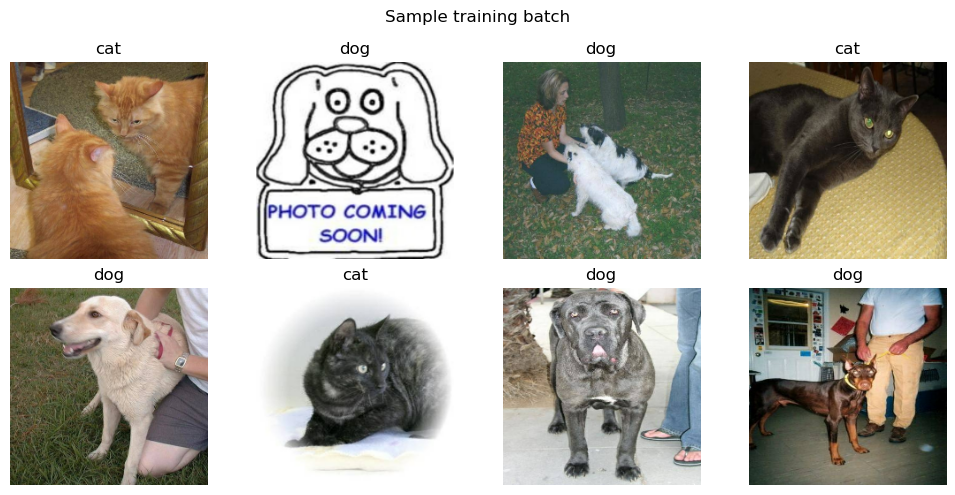

In [11]:
# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
# if test_ds is not None:
#     test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Data augmentation & normalization pipeline
# Using Keras preprocessing layers so it runs on GPU as part of the model

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name='augmentation')

preprocess = layers.Rescaling(1./255)

def show_batch(dataset, title=""):
    images, labels = next(iter(dataset))
    # Flatten to (batch,) and cast to int indices {0,1}
    labels = tf.cast(tf.squeeze(labels), tf.int32)
    plt.figure(figsize=(10, 5))
    for i in range(min(8, images.shape[0])):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[int(labels[i].numpy())])
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()

show_batch(train_ds, title="Sample training batch")

In [12]:
# Baseline CNN (Sequential)

def build_baseline_cnn(input_shape=(224,224,3), num_classes=2):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        preprocess,
        data_augmentation,
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        # Binary classification: single-unit sigmoid
        layers.Dense(1, activation='sigmoid')
    ], name='baseline_cnn')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=3e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

baseline = build_baseline_cnn(input_shape=IMG_SIZE + (3,), num_classes=num_classes)
baseline.summary()

Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,561 (49.36 MB)

 Trainable params: 12,938,561 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.5367 - loss: 0.7481
Epoch 1: val_accuracy improved from None to 0.53000, saving model to models\baseline_best.keras

Epoch 1: val_accuracy improved from None to 0.53000, saving model to models\baseline_best.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 260ms/step - accuracy: 0.5418 - loss: 0.7031 - val_accuracy: 0.5300 - val_loss: 0.6918
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 260ms/step - accuracy: 0.5418 - loss: 0.7031 - val_accuracy: 0.5300 - val_loss: 0.6918
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5907 - loss: 0.6671
Epoch 2: val_accuracy improved from 0.53000 to 0.58400, saving model to models\baseline_best.keras

Epoch 2: val_accuracy improved from 0.53000 to 0.58400, saving model to models\baseline_best.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 260ms/step - accuracy: 0.6145 - loss: 0.6549 - val_accuracy: 0.5840 - val_loss: 0.7007
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 260ms/step - accu

Text(0.5, 0, 'epoch')

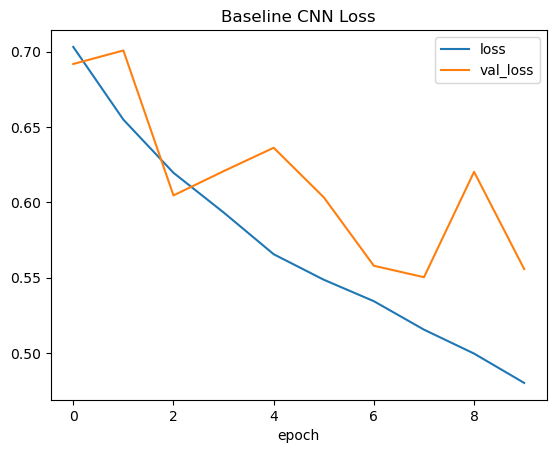

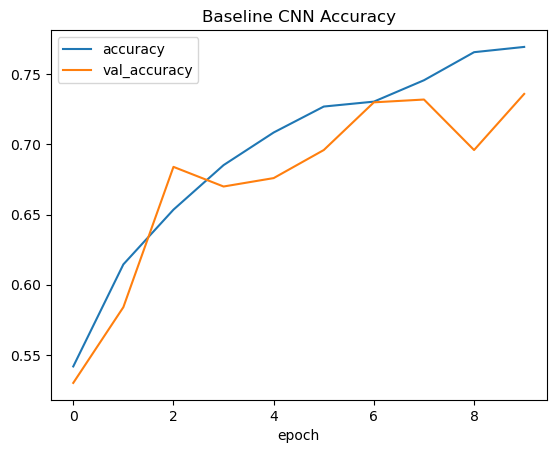

In [13]:
# Train baseline
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=str(MODELS_DIR / 'baseline_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy'),
]

history_baseline = baseline.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=1,
)

# Save final model snapshot as well
baseline.save(MODELS_DIR / 'baseline_final.keras')

# Plot learning curves
import pandas as pd
hist = pd.DataFrame(history_baseline.history)
ax = hist[['loss','val_loss']].plot(title='Baseline CNN Loss')
ax.set_xlabel('epoch')
ax = hist[['accuracy','val_accuracy']].plot(title='Baseline CNN Accuracy')
ax.set_xlabel('epoch')

Validation classification report (Baseline):
              precision    recall  f1-score   support

         cat     0.8010    0.6280    0.7040       250
         dog     0.6941    0.8440    0.7617       250

    accuracy                         0.7360       500
   macro avg     0.7475    0.7360    0.7329       500
weighted avg     0.7475    0.7360    0.7329       500



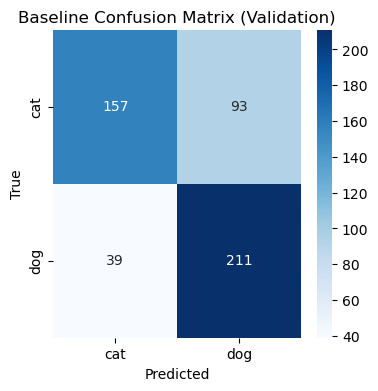

In [14]:
# Evaluate baseline on validation set
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Collect predictions on validation dataset
y_true, y_pred = [], []
for xb, yb in val_ds:
    probs = baseline.predict(xb, verbose=0).ravel()
    y_pred.extend((probs >= 0.5).astype(int))
    y_true.extend(yb.numpy().ravel().astype(int))
y_true = np.array(y_true)
y_pred = np.array(y_pred)
print('Validation classification report (Baseline):')
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Baseline Confusion Matrix (Validation)')
plt.show()

## Transfer Learning: MobileNetV2

Transfer learning using Keras Applications: MobileNetV2. It will be trained in two stages (frozen, then fine-tuned) and evaluated on the validation set.

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "mobilenetv2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.8817 - loss: 0.2932
Epoch 1: val_accuracy improved from None to 0.97200, saving model to models\mobilenetv2_best_frozen.keras

Epoch 1: val_accuracy improved from None to 0.97200, saving model to models\mobilenetv2_best_frozen.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - accuracy: 0.9342 - loss: 0.1799 - val_accuracy: 0.9720 - val_loss: 0.0815
Epoch 2/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - accuracy: 0.9342 - loss: 0.1799 - val_accuracy: 0.9720 - val_loss: 0.0815
Epoch 2/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9565 - loss: 0.1065
Epoch 2: val_accuracy did not improve from 0.97200
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9670 - loss: 0.0917 - val_accuracy: 0.9720 - val_loss: 0.0695
Epoch 3/8

Epoch 2: val_accuracy did not improve from 0.97200
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9670 - loss: 0.0917 - val_accuracy: 0.9720 - val_loss: 0.0695
Epoch 3/8


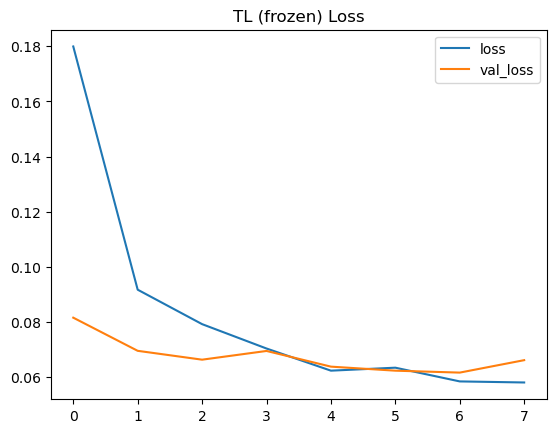

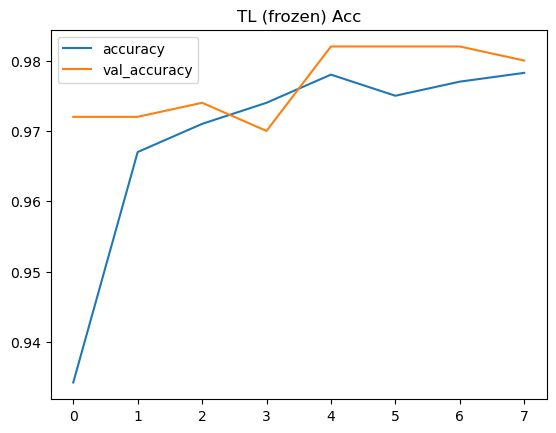

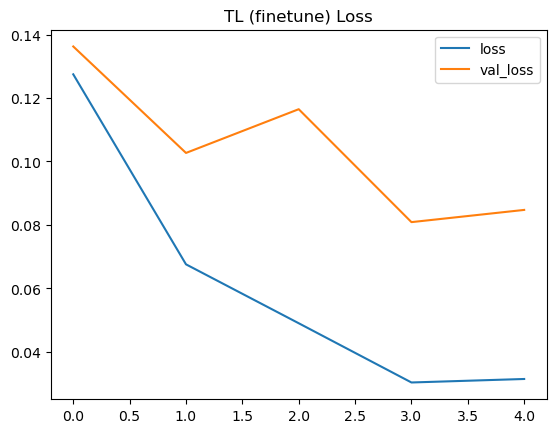

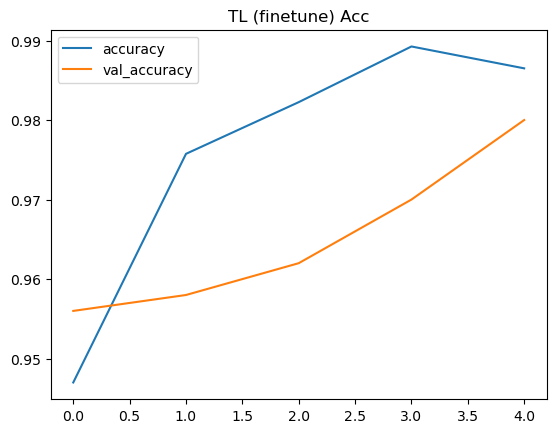

In [ ]:
base = keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base.trainable = False  # freeze base initially

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = preprocess(inputs)
x = data_augmentation(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
# Binary classification: single-unit sigmoid
outputs = layers.Dense(1, activation='sigmoid')(x)
transfer = keras.Model(inputs, outputs, name='mobilenetv2_transfer')

transfer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
transfer.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=str(MODELS_DIR / 'mobilenetv2_best_frozen.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy')
]

history_transfer = transfer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=callbacks,
    verbose=1,
)

# Fine-tune: unfreeze last few layers
base.trainable = True
for layer in base.layers[:-20]:
    layer.trainable = False
transfer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks_ft = [
    keras.callbacks.ModelCheckpoint(
        filepath=str(MODELS_DIR / 'mobilenetv2_best_finetune.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor='val_accuracy')
]

history_transfer_ft = transfer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks_ft,
    verbose=1,
)

# Save final finetuned model snapshot
transfer.save(MODELS_DIR / 'mobilenetv2_final.keras')

# Plot TL curves
import pandas as pd
hist_tl = pd.DataFrame(history_transfer.history)
hist_tl_ft = pd.DataFrame(history_transfer_ft.history)
ax = hist_tl[['loss','val_loss']].plot(title='TL (frozen) Loss')
ax = hist_tl[['accuracy','val_accuracy']].plot(title='TL (frozen) Acc')
ax = hist_tl_ft[['loss','val_loss']].plot(title='TL (finetune) Loss')
ax = hist_tl_ft[['accuracy','val_accuracy']].plot(title='TL (finetune) Acc')

Validation classification report (MobileNetV2 TL):
              precision    recall  f1-score   support

         cat     0.9878    0.9720    0.9798       250
         dog     0.9724    0.9880    0.9802       250

    accuracy                         0.9800       500
   macro avg     0.9801    0.9800    0.9800       500
weighted avg     0.9801    0.9800    0.9800       500



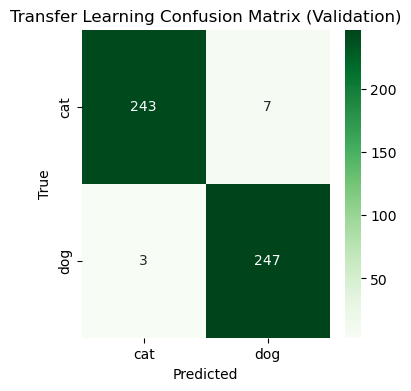

In [16]:
# Evaluate transfer model on validation set
from sklearn.metrics import classification_report, confusion_matrix

y_true, y_pred = [], []
for xb, yb in val_ds:
    probs = transfer.predict(xb, verbose=0).ravel()
    y_pred.extend((probs >= 0.5).astype(int))
    y_true.extend(yb.numpy().ravel().astype(int))
y_true = np.array(y_true)
y_pred = np.array(y_pred)
print('Validation classification report (MobileNetV2 TL):')
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Transfer Learning Confusion Matrix (Validation)')
plt.show()

## Transfer Learning: VGG16 and ResNet50

We add two more backbones for transfer learning using Keras Applications: VGG16 and ResNet50. Each will be trained in two stages (frozen, then fine-tuned) and evaluated on the validation set.

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/8
Epoch 1/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5949 - loss: 0.6695
Epoch 1: val_accuracy improved from None to 0.71400, saving model to models\vgg16_best_frozen.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.6298 - loss: 0.6509 - val_accuracy: 0.7140 - val_loss: 0.6010
Epoch 2/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7145 - loss: 0.6019
Epoch 2: val_accuracy improved from 0.71400 to 0.76400, saving model to models\vgg16_best_frozen.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.7340 - loss: 0.5888 - val_accuracy: 0.7640 - val_loss: 0.5410
Epoch 3/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7723 - loss: 0.5562
Epoch 3: val_accuracy improved from 0.76400 to 0.81400, saving model to models\vgg16_best_frozen.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.7803 - loss: 0.5452 - val_accuracy: 0.

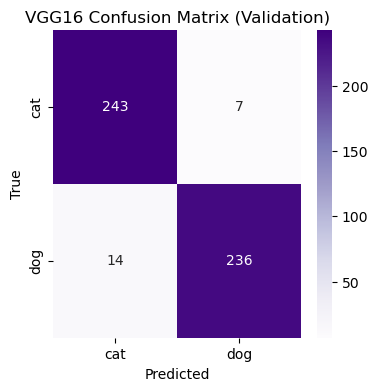

In [17]:
# VGG16 Transfer Learning
vgg_base = keras.applications.VGG16(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
vgg_base.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = preprocess(inputs)
x = data_augmentation(x)
x = vgg_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
# Binary classification: single-unit sigmoid
outputs = layers.Dense(1, activation='sigmoid')(x)
vgg_model = keras.Model(inputs, outputs, name='vgg16_transfer')

vgg_model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

callbacks_vgg = [
    keras.callbacks.ModelCheckpoint(
        filepath=str(MODELS_DIR / 'vgg16_best_frozen.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy')
]

hist_vgg = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=callbacks_vgg,
    verbose=1,
)

# Fine-tune last blocks
vgg_base.trainable = True
for layer in vgg_base.layers[:-4]:
    layer.trainable = False
vgg_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

callbacks_vgg_ft = [
    keras.callbacks.ModelCheckpoint(
        filepath=str(MODELS_DIR / 'vgg16_best_finetune.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor='val_accuracy')
]

hist_vgg_ft = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks_vgg_ft,
    verbose=1,
)

# Save final finetuned model
vgg_model.save(MODELS_DIR / 'vgg16_final.keras')

# Evaluate VGG16 on validation
from sklearn.metrics import classification_report, confusion_matrix

y_true, y_pred = [], []
for xb, yb in val_ds:
    probs = vgg_model.predict(xb, verbose=0).ravel()
    y_pred.extend((probs >= 0.5).astype(int))
    y_true.extend(yb.numpy().ravel().astype(int))
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
y_true = np.array(y_true); y_pred = np.array(y_pred)
print('VGG16 Validation Report:')
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.title('VGG16 Confusion Matrix (Validation)'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.5127 - loss: 0.7293
Epoch 1: val_accuracy improved from None to 0.61600, saving model to models\resnet50_best_frozen.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 566ms/step - accuracy: 0.5285 - loss: 0.7107 - val_accuracy: 0.6160 - val_loss: 0.6709
Epoch 2/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.5639 - loss: 0.6830
Epoch 2: val_accuracy did not improve from 0.61600
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 507ms/step - accuracy: 0.5663 - loss: 0.6808 - val_accuracy: 0.6120 - val_loss: 0.6655
Epoch 3/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.5648 - loss: 0.6794
Epoch 3: val_accuracy did not improve from 0.61600
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 509ms/step - accuracy: 0.5770 - loss: 0.6737 - val_accuracy: 0.5760 - val_loss: 0.6719
Epoch 4/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.5909 - loss: 0.6682
Epoch 4: val_accuracy did not improv

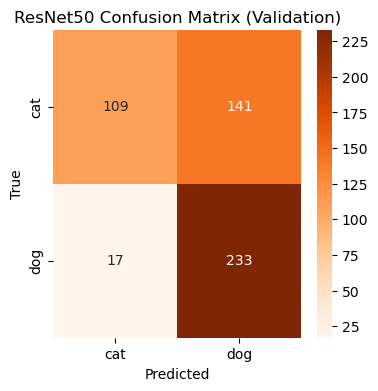

In [18]:
# ResNet50 Transfer Learning
resnet_base = keras.applications.ResNet50(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
resnet_base.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = preprocess(inputs)
x = data_augmentation(x)
x = resnet_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
# Binary classification: single-unit sigmoid
outputs = layers.Dense(1, activation='sigmoid')(x)
resnet_model = keras.Model(inputs, outputs, name='resnet50_transfer')

resnet_model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

callbacks_resnet = [
    keras.callbacks.ModelCheckpoint(
        filepath=str(MODELS_DIR / 'resnet50_best_frozen.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy')
]

hist_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=callbacks_resnet,
    verbose=1,
)

# Fine-tune last stages
resnet_base.trainable = True
for layer in resnet_base.layers[:-20]:
    layer.trainable = False
resnet_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

callbacks_resnet_ft = [
    keras.callbacks.ModelCheckpoint(
        filepath=str(MODELS_DIR / 'resnet50_best_finetune.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor='val_accuracy')
]

hist_resnet_ft = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks_resnet_ft,
    verbose=1,
)

# Save final finetuned model
resnet_model.save(MODELS_DIR / 'resnet50_final.keras')

# Evaluate ResNet50 on validation
from sklearn.metrics import classification_report, confusion_matrix

y_true, y_pred = [], []
for xb, yb in val_ds:
    probs = resnet_model.predict(xb, verbose=0).ravel()
    y_pred.extend((probs >= 0.5).astype(int))
    y_true.extend(yb.numpy().ravel().astype(int))
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
y_true = np.array(y_true); y_pred = np.array(y_pred)
print('ResNet50 Validation Report:')
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
plt.title('ResNet50 Confusion Matrix (Validation)'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

## Unlabeled test set: load and run predictions

Loads images from `datasets_subset/test` without labels and generates predictions using any trained models in this notebook. CSVs are saved under `outputs/`.

In [23]:
from tensorflow import keras
baseline = keras.models.load_model('models/baseline_final.keras')
transfer = keras.models.load_model('models/mobilenetv2_final.keras')
vgg_model = keras.models.load_model('models/vgg16_final.keras')
resnet_model = keras.models.load_model('models/resnet50_final.keras')

In [21]:
from tensorflow import keras
baseline = keras.models.load_model('models/baseline_best.keras')
transfer = keras.models.load_model('models/mobilenetv2_best_finetune.keras')
vgg_model = keras.models.load_model('models/vgg16_best_finetune.keras')
resnet_model = keras.models.load_model('models/resnet50_best_finetune.keras')

In [24]:
from pathlib import Path
import pandas as pd
import numpy as np

OUTPUT_DIR = Path('outputs'); OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
TEST_DIR = Path('datasets_subset') / 'test'
assert TEST_DIR.exists(), f"Missing folder: {TEST_DIR}"

# Load unlabeled test images as filepaths (no labels)
# We will map filenames to predictions later
img_paths = sorted([p for p in TEST_DIR.rglob('*') if p.suffix.lower() in {'.jpg','.jpeg','.png','.bmp','.gif','.webp'}])
print(f"Found {len(img_paths)} test images")

# Build a tf.data pipeline for efficient batching
import tensorflow as tf

def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return img

test_unlabeled_ds = tf.data.Dataset.from_tensor_slices([str(p) for p in img_paths])\
    .map(lambda p: load_img(p), num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)

# Helper to run predictions with a binary sigmoid model and save CSV
label_names = class_names  # e.g., ['cat','dog'] with alphabetical order
print(f"Label mapping: 0={label_names[0]}, 1={label_names[1]}")

def predict_and_save(model, name: str):
    probs = []
    for xb in test_unlabeled_ds:
        pr = model.predict(xb, verbose=0).ravel()
        probs.extend(pr.tolist())
    probs = tf.convert_to_tensor(probs)
    preds = (probs >= 0.5).numpy().astype(int)

    # Print numeric mapping and a quick preview of predictions
    print(f"Using mapping: 0={label_names[0]}, 1={label_names[1]}")
    print("First 10 predictions (0/1):", preds[:10].tolist())
    counts = np.bincount(preds, minlength=2)
    print(f"Counts -> 0: {counts[0]}, 1: {counts[1]}")

    pred_labels = [label_names[i] for i in preds]
    df = pd.DataFrame({
        'filename': [p.name for p in img_paths],
        'filepath': [str(p) for p in img_paths],
        'prob_dog': probs.numpy(),
        'pred_label': pred_labels,
        'pred_id': preds,  # 0=cat, 1=dog
    })
    csv_path = OUTPUT_DIR / f"predictions_{name}.csv"
    df.to_csv(csv_path, index=False)
    print(f"Saved predictions to {csv_path}")

# Uncomment to run on a trained model:
predict_and_save(baseline, 'baseline')
predict_and_save(transfer, 'mobilenetv2')
predict_and_save(vgg_model, 'vgg16')
predict_and_save(resnet_model, 'resnet50')

Found 500 test images
Label mapping: 0=cat, 1=dog
Using mapping: 0=cat, 1=dog
First 10 predictions (0/1): [0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Counts -> 0: 199, 1: 301
Saved predictions to outputs\predictions_baseline.csv
Using mapping: 0=cat, 1=dog
First 10 predictions (0/1): [0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Counts -> 0: 232, 1: 268
Saved predictions to outputs\predictions_mobilenetv2.csv
Using mapping: 0=cat, 1=dog
First 10 predictions (0/1): [0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Counts -> 0: 247, 1: 253
Saved predictions to outputs\predictions_vgg16.csv
Using mapping: 0=cat, 1=dog
First 10 predictions (0/1): [1, 1, 0, 1, 1, 0, 1, 1, 1, 0]
Counts -> 0: 113, 1: 387
Saved predictions to outputs\predictions_resnet50.csv
